In [33]:
import numpy as np
import pandas as pd
import matplotlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import json
import datetime
import h5py
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Activation, Input, SimpleRNN, Dense, LSTM
from tensorflow.keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam

print('numpy v{}'.format(np.__version__))                 # v1.14.3
print('pandas v{}'.format(pd.__version__))                # v0.23.0
print('tensorflow v{}'.format(tf.__version__))            # v1.8.0
print('matplotlib v{}'.format(matplotlib.__version__))    # v2.2.2

%matplotlib inline

numpy v1.18.2
pandas v1.0.3
tensorflow v2.2.0
matplotlib v3.2.1


# LOAD and VISUALIZE INPUTS

In [35]:
# %%
def load_data(file_path):
    data = pd.read_csv(file_path,names=["Name"])
    return data



In [37]:
# %%
# Load data
femaleData    = load_data('./female.txt')
maleData      = load_data('./male.txt')
femaleData.insert(1,"Sex",'Female')
maleData.insert(1,"Sex",'Male')
dataSet=maleData.append(femaleData)
dataSet

,Name,Sex
0,Aamir,Male
1,Aaron,Male
2,Abbey,Male
3,Abbie,Male
4,Abbot,Male
...,...,...
4996,Zuzana,Female
4997,Mikako,Female
4998,Kaari,Female
4999,Gita,Female


<Figure size 432x288 with 0 Axes>

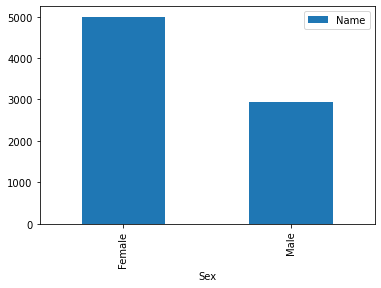

<Figure size 432x288 with 0 Axes>

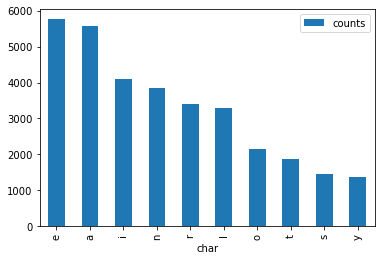

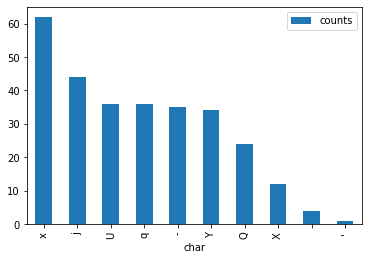

In [39]:
# Visualize dataSet data

plt.figure('Races')
dataSet.groupby('Sex').count().plot.bar()

plt.figure('Chars')
dataSet_chars = pd.DataFrame(data={'char': list(dataSet['Name'].str.cat())})
dataSet_chars_count = dataSet_chars.groupby('char').size().reset_index(name='counts')
dataSet_chars_count = dataSet_chars_count.set_index('char').sort_values('counts', ascending =False)

dataSet_chars_count[:10].plot(kind="bar")
dataSet_chars_count[-10:].plot(kind="bar")

# CLEAN DATA

In [41]:
def clean_data(data, padding_start = '#', padding_end = '*', verbose=True):
    # Create a copy
    data_cleaned = data.copy()
    
    # ReName the grouping column
    data_cleaned = data_cleaned.rename(columns={'Sex': 'group'})
    
    # Cleaning operations
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.strip(" -."))        # remove unwanted starting/ending chars
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.rstrip(" VI"))       # remove unwanted starting/ending chars
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.replace('\xad', '')) # remove soft hyphen
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.replace('#', ''))    # replace characters used for training
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.replace('*', ''))    # replace characters used for training
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: n.split(',', 1)[0])    # remove titles
    data_cleaned['Name'] = data_cleaned['Name'].map(lambda n: padding_start + n + padding_end) # Add padding chars
    # padding characters is used to ease the training data generation
    
    print('{} rows cleaned !'.format(len(data_cleaned))) if verbose else None
    
    return data_cleaned

7944 rows cleaned !


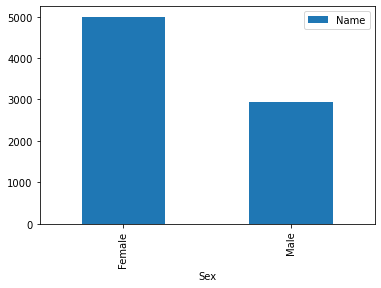

In [43]:
padding_start = '#'
padding_end = '*'
data_cleaned = clean_data(dataSet, padding_start, padding_end)  
data_cleaned.groupby('group').count().plot.bar()

# TRANSFORM DATA

In [45]:
def build_inputs(data_cleaned, verbose=True):
    '''
    Build data for RNN model
    
    ## Inputs:
    data_cleaned (DataFrame): including 2 series 'name' and 'group'
    verbose (boolean): show some feedbacks
    ## Outputs:
    data_dict (dict): dictionary with one entry per group
                        Each group entry is a dictionnary with
                            - group (string)
                            - name_list (list): list of strings
                            - char_list (list): list of unique characters included in all names
                            - char_to_ix (dict): to transform a character in its corresponding index in char_list
                            - ix_to_char (dict): to transform a index in its corresponding character in char_list
    '''
    groups = data_cleaned['Sex'].unique()

    data_dict = {}

    for r in groups:
        data_dict[r] = {}
        data_dict[r]['group'] = r
        data_dict[r]['name_list'] = data_cleaned[data_cleaned['group'] == r]['Name']
        data_dict[r]['char_list'] = sorted(list(set(data_dict[r]['name_list'].str.cat() + '*')))
        data_dict[r]['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict[r]['char_list']) }
        data_dict[r]['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict[r]['char_list']) }

    
    return data_dict

In [47]:
# Build model input data

# Create a data dictionnary
data_dict = build_inputs(data_cleaned)

In [49]:
def init_training_data(
    target_group, data_dict,
    length_of_sequence = 3, verbose = True):
    '''
    Initialise training data X and Y and some helpers
    
    ## Inputs:
    target_group (string) : key to select names in data_dict (e.g. 'Man', 'Elf', ..., 'Real')
    data_dict (dict): dictionary with one entry per group
                        Each group entry is a dictionnary with
                            - group (string)
                            - name_list (list): list of strings
                            - char_list (list): list of unique characters included in all names
                            - char_to_ix (dict): to transform a character in its corresponding index in char_list
                            - ix_to_char (dict): to transform a index in its corresponding character in char_list
    length_of_sequence (integer): size of the input sequence of the RNN 
        To be choosen by the user:
            - bigger length means more weights in the RNN, slower training but higher "memory" capabilities
            - smaller length means easier to train but kind of "oblivious" RNN
    verbose (boolean): show some feedbacks
    ## Outputs:
    X (ndarray): shape (m, length_of_sequence, number_of_chars) of boolean data
    Y (ndarray): shape (m, number_of_chars) of boolean data
    (c2i, i2c): utils dictionnary used to convert character to index of "one hot vector" and vice versa
    trainset_infos (dict): description of the dataset
        - target_group (string): cf Inputs
        - length_of_sequence (integer): size of the input sequence for the RNN model
        - number_of_chars (integer): number of unique character in the trainset
    '''

    # Extract target names to list (currently '#name*')
    training_names = data_dict[target_group]['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict[target_group]['char_to_ix']
    i2c = data_dict[target_group]['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict[target_group]['char_list'])
    
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if verbose else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))

        # visual feedback
        if verbose:
            counter += 1
            print(counter) if counter % 100 == 0 else print('.', end='')

    # Convert X and Y to numpy array
    X = np.array(X_list)
    Y = np.array(Y_list)
    
    # Extract the number of training samples
    m = len(X)

    print(
        '{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if verbose else None
    
    # Create a description of the trainset
    trainset_infos = {
        'target_group': target_group,
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    # Visual feedbacks
    if verbose:
        print('X shape: {}'.format(X.shape))
        print('Y shape: {}'.format(Y.shape))

        print('X[0] = {}'.format(X[0]))
        print('Y[0] = {}'.format(Y[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
    
    return X, Y, {'c2i': c2i, 'i2c': i2c}, trainset_infos

In [51]:
X, Y, trainset_utils, trainset_infos = init_training_data(
    target_group = 'Male',
    data_dict = data_dict,
    length_of_sequence = 5,
)

...................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
.........................................................................

# CREATE MODEL

In [53]:
def create_model(trainset_infos, lstm_units = 256, verbose = True):
    '''
    Create the Keras RNN model and some helpers
    
    ## Inputs:
    trainset_infos (dict): description of the trainset to be used on the model (cf. init_training_data)
        - m (integer): number of 
        - length_of_sequence (integer): size of an input sample (number of characters)
        - number_of_chars (integer): size of the character dictionnary (number of different character in all input samples)
    verbose (boolean): show some feedbacks
    ## Outputs:
    model (keras model):
        - Architecture:
            * One Input layer taking an undefined batch size of sequences. Each sequence is length_of_sequence long
                and each character is encoded in a number_of_chars "one-hot vector"
            * One LSTM layer with 256 units
            * One Dense layer converting 256 to number_of_chars
            * One Softmax layer to 
    training_infos (dict): description of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
        - trainset_infos (dict): description of the trainset
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    '''
    length_of_sequence = trainset_infos['length_of_sequence']
    number_of_chars = trainset_infos['number_of_chars']
    
    X_input = Input(shape=(length_of_sequence, number_of_chars))
    
    #X = SimpleRNN(units=number_of_chars)(X_input)
    X = LSTM(units=lstm_units)(X_input) # default 256
    X = Dense(units=number_of_chars)(X)
    
    Output = Activation('softmax')(X)
    
    model = Model(inputs=X_input, outputs=Output)
    training_infos = {
        'total_epochs': 0,
        'loss': 0,
        'acc': 0,
        'trainset_infos': trainset_infos,
    }
    history = {
        'loss': np.array([]),
        'accuracy': np.array([]),
        'hyperparams': []
    }
    model.summary()
    return model, training_infos, history

In [55]:
current_model, training_infos, history = create_model(trainset_infos = trainset_infos, lstm_units= 64)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 55)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                30720     
_________________________________________________________________
dense_1 (Dense)              (None, 55)                3575      
_________________________________________________________________
activation_1 (Activation)    (None, 55)                0         
Total params: 34,295
Trainable params: 34,295
Non-trainable params: 0
_________________________________________________________________


# TRAIN MODEL

In [57]:
def compile_model(model, hyperparams, history, verbose=True):
    '''
    Compile the Keras model with new hyperparams on Adam optimizer and save this hyperparams in history
    
    ## Inputs:
    model (Keras model): Keras RNN model
    hyperparams (dict): List of hyperparams
        - lr (float): learning rate
        - loss (string): loss function
        - batch_size (int): batch size
    verbose (boolean): show some feedbacks
    ## Outputs:
    None
    '''
    optimizer = Adam(lr=hyperparams['lr'])

    model.compile(loss=hyperparams['loss'], optimizer=optimizer, metrics = ["accuracy"])

    history['hyperparams'].append((training_infos['total_epochs'], hyperparams))
    
    print(history) if verbose else None
    
    return None

In [59]:
compile_model(
    model = current_model,
    hyperparams = {
        'lr': 0.003,                       # default 0.003
        'loss': 'categorical_crossentropy', # default 'categorical_crossentropy'
        'batch_size': 32,                   # default 32
    },
    history = history
)

{'loss': array([], dtype=float64), 'accuracy': array([], dtype=float64), 'hyperparams': [(0, {'lr': 0.003, 'loss': 'categorical_crossentropy', 'batch_size': 32}), (0, {'lr': 0.003, 'loss': 'categorical_crossentropy', 'batch_size': 32})]}


In [61]:
def train_model(model, X, Y, training_infos, history, epochs_to_add = 10, verbose = True):
    '''
    Train the Keras model then update training session info and history
    
    ## Inputs:
    model (Keras model): Keras RNN model
    X (ndarray): Input of the training. List of sequences of encoded characters.
        Numpy array of shape (m, length_of_sequence, number_of_chars)
    Y (ndarray): Ouput to be predicted. List of encoded character expected the corresponding input sequence.
        Numpy array of shape (m, number_of_chars)
    training_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    verbose (boolean): show some feedbacks
    ## Outputs:
    None
    '''
    # Extract previous loss and accuracy to give feedback at the end of the session
    old_loss = training_infos['loss']
    old_acc = training_infos['acc']
    
    # Extract hyperparams to fit the model
    hyperparams = history['hyperparams'][-1][1]
    
    # Train the model
    h = model.fit(
        X, Y,
        batch_size=hyperparams['batch_size'],
        initial_epoch=training_infos['total_epochs'],
        epochs = training_infos['total_epochs'] + epochs_to_add
    )


    # Update history
    for key, val in h.history.items():
        print("Key:{0},Val:{1}",key,val)
        history[key] = np.append(history[key], val)
    
    # Update the training session info
    training_infos['total_epochs'] += epochs_to_add
    training_infos['loss'] = history['loss'][-1]
    training_infos['acc' ] = history['accuracy' ][-1]
    
    if verbose:
        print('new loss: {:.5f} ({:.5f})'.format(training_infos['loss'], training_infos['loss'] - old_loss))
        print('new acc : {:.5f} ({:.5f})'.format(training_infos['acc'], training_infos['acc'] - old_acc))
        print('history size: {}'.format(len(history['loss'])))

    return None

In [62]:
train_model(current_model, X, Y, training_infos, history, epochs_to_add = 2, verbose = True)

Epoch 1/2
1003/1003 [==============================] - 4s 4ms/step - loss: 1.7184 - accuracy: 0.5210
Epoch 2/2
1003/1003 [==============================] - 4s 4ms/step - loss: 1.4698 - accuracy: 0.5496
Key:{0},Val:{1} loss [1.7183798551559448, 1.469773530960083]
Key:{0},Val:{1} accuracy [0.5209730267524719, 0.5496335625648499]
new loss: 1.46977 (1.46977)
new acc : 0.54963 (0.54963)
history size: 2


# BACKUP et RESTORE

In [429]:
def backup_model_to_disk(
    model,
    dict_to_pkl,
#     trainset_infos,
#     trainset_utils,
#     training_infos,
#     history,
    directory='./model/'
):
    '''
    Backup model to disk
    
    ## Inputs:
    model (Keras model): model to backup
    trainset_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    trainset_utils (dict): trainset_utils (dict): utils dictionnary used to convert character to index of "one hot vector" and vice versa
        - c2i (dict): character to index
        - i2c (dict): index to character
    training_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    directory (string): path to backup directory
    ## Outputs:
    %Y%m%d-%H%M_Group_Loss_model_infos.txt (txt file)
    %Y%m%d-%H%M_model.json (json file)
    %Y%m%d-%H%M_model_weights.h5 (h5 file)
    %Y%m%d-%H%M_trainset_infos.pkl (pkl file)
    %Y%m%d-%H%M_trainset_utils.pkl (pkl file)
    %Y%m%d-%H%M_training_infos.pkl (pkl file)
    %Y%m%d-%H%M_history.pkl (pkl file)
    '''
    # File Naming format
    now = datetime.datetime.now()
    prefix = now.strftime("%Y%m%d-%H%M") + '_'
    
    # Init list of saved files
    saved_files = []

    # Model summary to txt
    desc = '{}_{:.4f}_'.format(trainset_infos['target_group'], training_infos['loss'])
    model_infos_target = directory + prefix + desc + "model_infos.txt"
    with open(model_infos_target, "w+") as f:
        f.write('training_infos:\n')
        f.write(json.dumps(training_infos, indent=2) + '\n')
        f.write('history["hyperparams"]:\n')
        f.write(json.dumps(history["hyperparams"], indent=2) + '\n')
        model.summary(print_fn=lambda line: f.write(line + '\n'))
    saved_files.append(model_infos_target)
    print("Saved model to disk {}".format(model_infos_target))

    # serialize model to JSON
    model_json_target = directory + prefix + "model.json"
    model_json = model.to_json()
    with open(model_json_target, "w") as json_file:
        json_file.write(model_json)
    saved_files.append(model_json_target)
    print("Saved model to disk {}".format(model_json_target))

    # serialize weights to HDF5
    model_weights_target = directory + prefix + "model_weights.h5"
    model.save_weights(model_weights_target)
    saved_files.append(model_weights_target)
    print("Saved model to disk {}".format(model_weights_target))
    
    # serialize trainset_infos to disk
    for name, data in dict_to_pkl.items():
        target = directory + prefix + name + '.pkl'
        with open(target, "wb") as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        saved_files.append(target)
        print("Saved model to disk {}".format(target))
    
    return (saved_files)

In [427]:
# Model Backup
backup_model_to_disk(
    model = current_model,
    dict_to_pkl = {
        'trainset_infos': trainset_infos,
        'trainset_utils': trainset_utils,
        'training_infos': training_infos,
        'history': history
    }
)

Saved model to disk ../data/temp/20180529-1637_Real_0.9290_model_infos.txt
Saved model to disk ../data/temp/20180529-1637_model.json
Saved model to disk ../data/temp/20180529-1637_model_weights.h5
Saved model to disk ../data/temp/20180529-1637_history.pkl
Saved model to disk ../data/temp/20180529-1637_trainset_utils.pkl
Saved model to disk ../data/temp/20180529-1637_trainset_infos.pkl
Saved model to disk ../data/temp/20180529-1637_training_infos.pkl


['../data/temp/20180529-1637_Real_0.9290_model_infos.txt',
 '../data/temp/20180529-1637_model.json',
 '../data/temp/20180529-1637_model_weights.h5',
 '../data/temp/20180529-1637_history.pkl',
 '../data/temp/20180529-1637_trainset_utils.pkl',
 '../data/temp/20180529-1637_trainset_infos.pkl',
 '../data/temp/20180529-1637_training_infos.pkl']